In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.4'
os.environ['OMP_NUM_THREADS']='1'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)
#os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=1'

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
   "NCCL_PROTO": "SIMPLE,LL,LL128",
 })

import sys
sys.path.append('../')

from models import scalar
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'classic'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CudaDevice(id=0)]

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


# 16x16

jack bin size 1: (np.float32(0.003559981), np.complex128(0.0001198993089513105+0j))
bin size 1: (np.float32(0.003559981), np.complex128(0.00011990134551381811+0j))
jack bin size 2: (np.float32(0.003559981), np.complex128(0.00016616860248677823+0j))
bin size 2: (np.float32(0.003559981), np.complex128(0.00016616854843756865+0j))
jack bin size 4: (np.float32(0.003559981), np.complex128(0.00022852752223321844+0j))
bin size 4: (np.float32(0.003559981), np.complex128(0.0002285271755981584+0j))
jack bin size 5: (np.float32(0.003559981), np.complex128(0.0002523341360845214+0j))
bin size 5: (np.float32(0.003559981), np.complex128(0.0002523335635520957+0j))
jack bin size 10: (np.float32(0.003559981), np.complex128(0.0003383678146177811+0j))
bin size 10: (np.float32(0.003559981), np.complex128(0.0003383683100943418+0j))
jack bin size 20: (np.float32(0.003559981), np.complex128(0.0004391616290682918+0j))
bin size 20: (np.float32(0.003559981), np.complex128(0.00043916189680241264+0j))
jack bin size

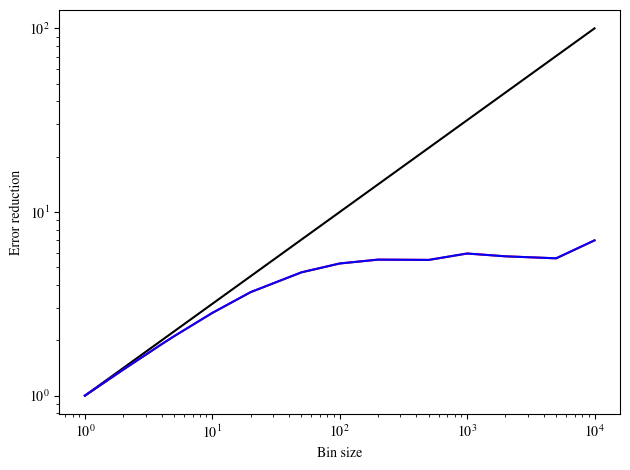

In [4]:
with open("1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 8))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [5]:
jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000:10])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:100000:100]))

((np.float32(0.0035733639), np.complex128(0.0018269160736232577+0j)),
 (np.float32(0.003664993), np.complex128(0.0018159802222430918+0j)),
 (np.float32(0.0037466763), np.complex128(0.0013367552145961727+0j)))

In [6]:
jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:5000])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:5000:10])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:50000:100]))

((np.float32(0.0032723916), np.complex128(0.002714385779448242+0j)),
 (np.float32(0.002867671), np.complex128(0.002605791378300637+0j)),
 (np.float32(0.0061721196), np.complex128(0.0018729680450633168+0j)))

In [20]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

## Correlated

In [7]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_1h_cor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 100 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 1.6973195670288987e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0041135293), np.complex128(0.00012021877104932775+0j)) <f>: (np.float32(-0.0008033856), np.complex128(0.0013654006044040887+0j))
Epoch 200: <Test loss>: 8.363530469068792e-06 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0042029056), np.complex128(9.973289211984072e-05+0j)) <f>: (np.float32(-0.00089275936), np.complex128(0.0013601811764412403+0j))
Epoch 300: <Test loss>: 5.385579697758658e-06 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004106143), np.complex128(7.308258434463936e-05+0j)) <f>: (np.float32(-0.0007959964), n

KeyboardInterrupt: 

In [17]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 5000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train5e3_1h_cor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 300:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 100 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 3.8803340430604294e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0040660813), np.complex128(0.00018642592014506685+0j)) <f>: (np.float32(-0.0007559332), np.complex128(0.0013675406168072992+0j))
Epoch 200: <Test loss>: 2.640999446157366e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0040614195), np.complex128(0.00016411317641249674+0j)) <f>: (np.float32(-0.00075127423), np.complex128(0.001320381056026774+0j))
Epoch 300: <Test loss>: 2.0644747564801946e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0041151587), np.complex128(0.00013166960235537817+0j)) <f>: (np.float32(-0.00080501253

## Less correlated

In [12]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*10:10]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_1h_lesscor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 480:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 7.070616993587464e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0038086204), np.complex128(0.0003171916006836953+0j)) <f>: (np.float32(-0.0004984736), np.complex128(0.00135238787263224+0j))
Epoch 2000: <Test loss>: 6.451654189731926e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003807981), np.complex128(0.0002848847586271894+0j)) <f>: (np.float32(-0.0004978356), np.complex128(0.0013816749236373485+0j))
Epoch 3000: <Test loss>: 5.650717866956256e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.00387733), np.complex128(0.00025288300059037467+0j)) <f>: (np.float32(-0.00056718255), np.

In [19]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 500
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*10:10]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train5e3_1h_lesscor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 300:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 0.00012618991604540497 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003915264), np.complex128(0.0004287480090012535+0j)) <f>: (np.float32(-0.0006051193), np.complex128(0.001156404524398189+0j))
Epoch 2000: <Test loss>: 0.0001022633514367044 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003929221), np.complex128(0.00042119954625800663+0j)) <f>: (np.float32(-0.00061907305), np.complex128(0.0012019055089643818+0j))
Epoch 3000: <Test loss>: 9.52078917180188e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0039239856), np.complex128(0.0003928995980159179+0j)) <f>: (np.float32(-0.0006138394), n

## not correlated

In [14]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*100:100]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_1h_notcor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 480:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 7.078117778291926e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0036656081), np.complex128(0.00033176402078865635+0j)) <f>: (np.float32(-0.0003554611), np.complex128(0.0013215891500522512+0j))
Epoch 2000: <Test loss>: 6.659529753960669e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0037704762), np.complex128(0.0002968838737589497+0j)) <f>: (np.float32(-0.0004603293), np.complex128(0.0013846416869346086+0j))
Epoch 3000: <Test loss>: 6.086563735152595e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0038585153), np.complex128(0.0002487962955658579+0j)) <f>: (np.float32(-0.0005483698),

In [21]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 500
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*100:100]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train5e3_1h_notcor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 480:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 0.00013046312960796058 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003588918), np.complex128(0.00033545750535284344+0j)) <f>: (np.float32(-0.00027877043), np.complex128(0.0013596951732687524+0j))
Epoch 2000: <Test loss>: 0.00010999697406077757 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0035916779), np.complex128(0.0003455206634462972+0j)) <f>: (np.float32(-0.00028153358), np.complex128(0.0013073457430581874+0j))
Epoch 3000: <Test loss>: 0.00011215556151000783 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.003627803), np.complex128(0.00034207982187819724+0j)) <f>: (np.float32(-0.00031765

## sweep1

jack bin size 1: (np.float32(0.003559981), np.complex128(0.0001198993089513105+0j))
bin size 1: (np.float32(0.003559981), np.complex128(0.00011990134551381811+0j))
jack bin size 2: (np.float32(0.003559981), np.complex128(0.00016616860248677823+0j))
bin size 2: (np.float32(0.003559981), np.complex128(0.00016616854843756865+0j))
jack bin size 4: (np.float32(0.003559981), np.complex128(0.00022852752223321844+0j))
bin size 4: (np.float32(0.003559981), np.complex128(0.0002285271755981584+0j))
jack bin size 5: (np.float32(0.003559981), np.complex128(0.0002523341360845214+0j))
bin size 5: (np.float32(0.003559981), np.complex128(0.0002523335635520957+0j))
jack bin size 10: (np.float32(0.003559981), np.complex128(0.0003383678146177811+0j))
bin size 10: (np.float32(0.003559981), np.complex128(0.0003383683100943418+0j))
jack bin size 20: (np.float32(0.003559981), np.complex128(0.0004391616290682918+0j))
bin size 20: (np.float32(0.003559981), np.complex128(0.00043916189680241264+0j))
jack bin size

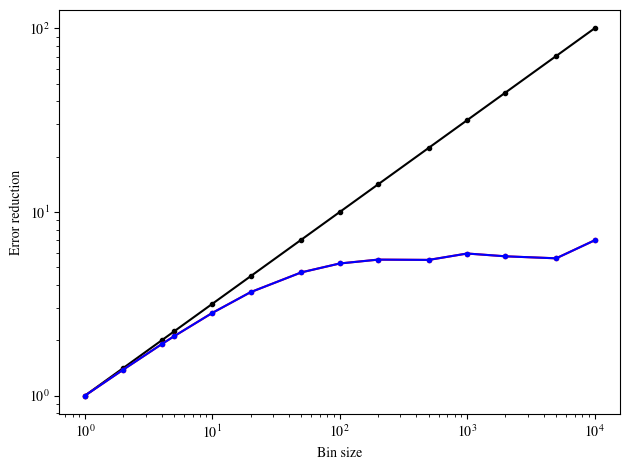

In [17]:
with open("1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [9]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [8]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs1_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 1.6973221136140637e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0041135307), np.complex128(0.00012021882655086468+0j)) <f>: (np.float32(-0.00080338574), np.complex128(0.0013654004775434329+0j))
Epoch 200: <Test loss>: 8.363538654521108e-06 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0042029032), np.complex128(9.973308241082446e-05+0j)) <f>: (np.float32(-0.0008927599), np.complex128(0.001360180795859273+0j))
Epoch 300: <Test loss>: 5.3856133490626235e-06 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0041061393), np.complex128(7.308318693275455e-05+0j)) <f>: (np.float32(-0.00079599564),

In [10]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 2.3292124751606025e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004075275), np.complex128(0.00014047548413284735+0j)) <f>: (np.float32(-0.0007651298), np.complex128(0.0013784689011431914+0j))
Epoch 400: <Test loss>: 1.4952930541767273e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0041482123), np.complex128(0.00010646453874414771+0j)) <f>: (np.float32(-0.0008380651), np.complex128(0.0014177388708769406+0j))
Epoch 600: <Test loss>: 1.203709325636737e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004107687), np.complex128(0.00011027122265729085+0j)) <f>: (np.float32(-0.00079754356),

In [12]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 4.509095015237108e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004069002), np.complex128(0.0003037577232496521+0j)) <f>: (np.float32(-0.0007588562), np.complex128(0.0013845972857050677+0j))
Epoch 800: <Test loss>: 3.3810218155849725e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004089366), np.complex128(0.00024528713953459304+0j)) <f>: (np.float32(-0.0007792186), np.complex128(0.0013894107595692575+0j))
Epoch 1200: <Test loss>: 3.0252027499955148e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004117064), np.complex128(0.0002367529219227946+0j)) <f>: (np.float32(-0.0008069177), np

In [14]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 6.935628334758803e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004074216), np.complex128(0.00030544027612793657+0j)) <f>: (np.float32(-0.0007640732), np.complex128(0.0012804257850302266+0j))
Epoch 1600: <Test loss>: 5.510691335075535e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004141088), np.complex128(0.00027262253449523587+0j)) <f>: (np.float32(-0.00083094166), np.complex128(0.001358651617513888+0j))
Epoch 2400: <Test loss>: 4.875925515079871e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.004144915), np.complex128(0.00024233333188180964+0j)) <f>: (np.float32(-0.00083477166), 

In [16]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.0016032276907935739 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 9.092804975807667e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0039144373), np.complex128(0.000357244205518429+0j)) <f>: (np.float32(-0.0006042919), np.complex128(0.0012416073123705793+0j))
Epoch 3200: <Test loss>: 8.228858496295288e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0039762864), np.complex128(0.0003670331860194683+0j)) <f>: (np.float32(-0.00066614186), np.complex128(0.001318094392705423+0j))
Epoch 4800: <Test loss>: 7.240556442411616e-05 <O>: (np.float32(0.0033101444), np.complex128(0.0014146631342763219+0j)) <O-f>: (np.float32(0.0040291143), np.complex128(0.0003515861885532094+0j)) <f>: (np.float32(-0.00071896997), 

## m^2=0.01, lambda=0.1

jack bin size 1: (np.float32(0.0655574), np.complex128(0.00043881599360227723+0j))
bin size 1: (np.float32(0.0655574), np.complex128(0.0004388045557918774+0j))
jack bin size 2: (np.float32(0.0655574), np.complex128(0.000618114463713151+0j))
bin size 2: (np.float32(0.0655574), np.complex128(0.0006180990855351279+0j))
jack bin size 4: (np.float32(0.0655574), np.complex128(0.0008692468800647937+0j))
bin size 4: (np.float32(0.0655574), np.complex128(0.0008692373835591271+0j))
jack bin size 5: (np.float32(0.0655574), np.complex128(0.0009693452423373169+0j))
bin size 5: (np.float32(0.0655574), np.complex128(0.000969348539370731+0j))
jack bin size 10: (np.float32(0.0655574), np.complex128(0.001354533404222054+0j))
bin size 10: (np.float32(0.0655574), np.complex128(0.0013545271031914542+0j))
jack bin size 20: (np.float32(0.0655574), np.complex128(0.0018751387205107606+0j))
bin size 20: (np.float32(0.0655574), np.complex128(0.0018751393911356272+0j))
jack bin size 50: (np.float32(0.0655574), np

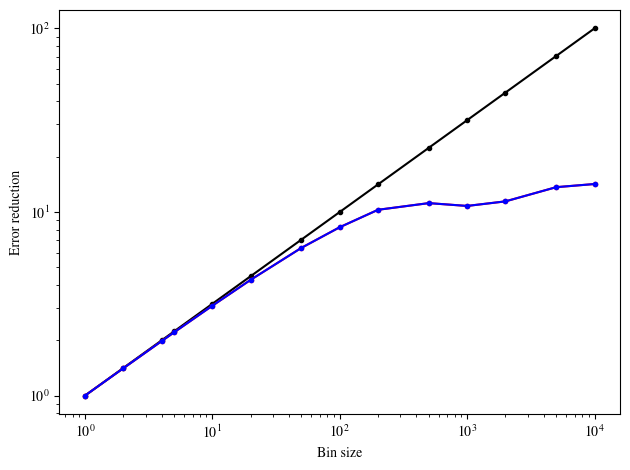

In [3]:
with open("1+1scalar/config/c_16x16_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16,16), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [49]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [16]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0005843210383318365 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07242963), np.complex128(0.0006564083678507742+0j)) <f>: (np.float32(0.006163756), np.complex128(0.005099431990825866+0j))
Epoch 200: <Test loss>: 0.0003326138248667121 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07275199), np.complex128(0.0005071747887637508+0j)) <f>: (np.float32(0.0058413236), np.complex128(0.0051470630926641146+0j))
Epoch 300: <Test loss>: 0.0002213131228927523 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.0729363), np.complex128(0.00048483025057931316+0j)) <f>: (np.float32(0.0056570787), np.complex128(0.00505

In [50]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.001182002481073141 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.072304554), np.complex128(0.0011533166091746104+0j)) <f>: (np.float32(0.006288764), np.complex128(0.004759756495527304+0j))
Epoch 400: <Test loss>: 0.00109788216650486 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07199479), np.complex128(0.0010258764538679317+0j)) <f>: (np.float32(0.00659855), np.complex128(0.004867897085541124+0j))
Epoch 600: <Test loss>: 0.0010320822475478053 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07202538), np.complex128(0.0009945013398981754+0j)) <f>: (np.float32(0.0065679546), np.complex128(0.0048256042

In [18]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [19]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.001718533574603498 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.0725089), np.complex128(0.0013923143462599137+0j)) <f>: (np.float32(0.0060845097), np.complex128(0.005273428991937218+0j))
Epoch 800: <Test loss>: 0.001601837924681604 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.0722155), np.complex128(0.0012678768558160953+0j)) <f>: (np.float32(0.0063778628), np.complex128(0.0052979709469716295+0j))
Epoch 1200: <Test loss>: 0.0014799785567447543 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07189159), np.complex128(0.0011543837610114595+0j)) <f>: (np.float32(0.006701796), np.complex128(0.00529663

In [20]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [21]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0022141034714877605 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.071263686), np.complex128(0.0010880032885446915+0j)) <f>: (np.float32(0.0073295855), np.complex128(0.005308499366520343+0j))
Epoch 1600: <Test loss>: 0.001996763749048114 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07100971), np.complex128(0.0010902355286446911+0j)) <f>: (np.float32(0.007583634), np.complex128(0.005197135500963172+0j))
Epoch 2400: <Test loss>: 0.0018621872877702117 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07098099), np.complex128(0.001042630433240888+0j)) <f>: (np.float32(0.00761237), np.complex128(0.0050397

In [22]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [23]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.002859971486032009 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07241719), np.complex128(0.0011498931475163593+0j)) <f>: (np.float32(0.0061761583), np.complex128(0.005264426452356838+0j))
Epoch 3200: <Test loss>: 0.0026999078691005707 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.072157726), np.complex128(0.0011421948623385762+0j)) <f>: (np.float32(0.0064356313), np.complex128(0.005149635826764364+0j))
Epoch 4800: <Test loss>: 0.002670699032023549 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07196334), np.complex128(0.0011725673331149735+0j)) <f>: (np.float32(0.0066300645), np.complex128(0.005

### l4, w64

In [4]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0016355796251446009 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07389028), np.complex128(0.0011700768047197023+0j)) <f>: (np.float32(0.004703042), np.complex128(0.005165851663235286+0j))
Epoch 200: <Test loss>: 0.0011793015291914344 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.074036084), np.complex128(0.0011391896602625995+0j)) <f>: (np.float32(0.0045572543), np.complex128(0.004906514991503903+0j))
Epoch 300: <Test loss>: 0.0010494478046894073 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07423557), np.complex128(0.000983772797664889+0j)) <f>: (np.float32(0.0043578064), np.complex128(0.004930

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0026672708336263895 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07328862), np.complex128(0.001353078502042583+0j)) <f>: (np.float32(0.0053047216), np.complex128(0.005056632757646903+0j))
Epoch 400: <Test loss>: 0.002237942535430193 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07372072), np.complex128(0.0013599363353754869+0j)) <f>: (np.float32(0.004872639), np.complex128(0.00546050532666473+0j))
Epoch 600: <Test loss>: 0.0019440618343651295 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07336547), np.complex128(0.0012752370573460893+0j)) <f>: (np.float32(0.0052279206), np.complex128(0.005366777

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0034662124235183 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07289432), np.complex128(0.001836855904323992+0j)) <f>: (np.float32(0.005699052), np.complex128(0.005186323420988021+0j))
Epoch 800: <Test loss>: 0.0027653377037495375 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07335595), np.complex128(0.001514909312538445+0j)) <f>: (np.float32(0.0052374047), np.complex128(0.005214449443270965+0j))
Epoch 1200: <Test loss>: 0.0023438462521880865 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07333531), np.complex128(0.0013145882178995701+0j)) <f>: (np.float32(0.0052580494), np.complex128(0.0052678131

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.004191759508103132 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07473144), np.complex128(0.002104332970618729+0j)) <f>: (np.float32(0.0038619256), np.complex128(0.005347277624352092+0j))
Epoch 1600: <Test loss>: 0.0032691163942217827 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07526188), np.complex128(0.0018950040082519291+0j)) <f>: (np.float32(0.0033315192), np.complex128(0.005012199559220838+0j))
Epoch 2400: <Test loss>: 0.0028734940569847822 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07484069), np.complex128(0.0017150890844067246+0j)) <f>: (np.float32(0.0037525923), np.complex128(0.00497

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.03014635480940342 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.005425841547548771 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.07336182), np.complex128(0.0026127819795248087+0j)) <f>: (np.float32(0.0052315597), np.complex128(0.004604380608921426+0j))
Epoch 3200: <Test loss>: 0.004636659752577543 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.073546745), np.complex128(0.002319015072079623+0j)) <f>: (np.float32(0.0050466075), np.complex128(0.004475444512761191+0j))
Epoch 4800: <Test loss>: 0.004503382369875908 <O>: (np.float32(0.078593336), np.complex128(0.0051883481170550815+0j)) <O-f>: (np.float32(0.074074455), np.complex128(0.002312302621058301+0j)) <f>: (np.float32(0.004518892), np.complex128(0.004295

# 32x32

jack bin size 1: (np.float32(-0.00026859494), np.complex128(4.165512866076346e-05+0j))
bin size 1: (np.float32(-0.00026859494), np.complex128(4.165511880292293e-05+0j))
jack bin size 2: (np.float32(-0.00026859494), np.complex128(5.771586174480367e-05+0j))
bin size 2: (np.float32(-0.00026859494), np.complex128(5.771588137737261e-05+0j))
jack bin size 4: (np.float32(-0.00026859494), np.complex128(7.934396848155021e-05+0j))
bin size 4: (np.float32(-0.00026859494), np.complex128(7.934399817653766e-05+0j))
jack bin size 5: (np.float32(-0.00026859494), np.complex128(8.761107903970432e-05+0j))
bin size 5: (np.float32(-0.00026859494), np.complex128(8.761109916150745e-05+0j))
jack bin size 10: (np.float32(-0.00026859494), np.complex128(0.00011723072219819025+0j))
bin size 10: (np.float32(-0.00026859494), np.complex128(0.00011723072634455652+0j))
jack bin size 20: (np.float32(-0.00026859494), np.complex128(0.00015163922532935542+0j))
bin size 20: (np.float32(-0.00026859494), np.complex128(0.0001

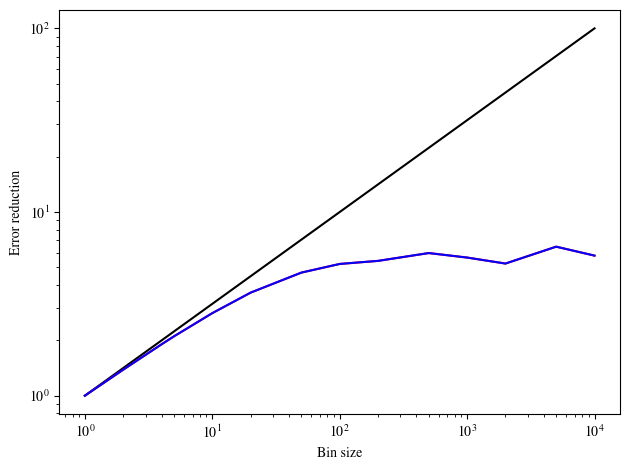

In [11]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

model = eval("scalar.Model(geom=(32,), nbeta=32, nt=0, m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [9]:
jackknife(jax.vmap(lambda x: model.observe(x, 16))(conf[:10000])), jackknife(jax.vmap(lambda x: model.observe(x, 16))(conf[:10000:10])), jackknife(jax.vmap(lambda x: model.observe(x, 16))(conf[:100000:100]))

((np.float32(0.0006155631), np.complex128(0.000617856441431765+0j)),
 (np.float32(0.00073884043), np.complex128(0.0007742307093962933+0j)),
 (np.float32(-2.4659561e-05), np.complex128(0.00038643335181240006+0j)))

In [ ]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

## Correlated, n_train=1e4, sweep=1

In [29]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_1h_cor.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 100 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 8.152605914801825e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00012160713), np.complex128(8.707070805521653e-05+0j)) <f>: (np.float32(0.00016599766), np.complex128(0.00037925421215344074+0j))
Epoch 200: <Test loss>: 3.459967047092505e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-3.21149e-06), np.complex128(6.069086323385103e-05+0j)) <f>: (np.float32(0.00029081642), np.complex128(0.00036783082239300475+0j))
Epoch 300: <Test loss>: 2.7249793674855027e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.0237556e-05), np.complex128(4.947342778376091e-05+0j)) <f>: (np.float32(0.0

In [37]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_30min_sweep1.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 100 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 8.152605914801825e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00012160713), np.complex128(8.707070805521653e-05+0j)) <f>: (np.float32(0.00016599766), np.complex128(0.00037925421215344074+0j))
Epoch 200: <Test loss>: 3.459967047092505e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-3.21149e-06), np.complex128(6.069086323385103e-05+0j)) <f>: (np.float32(0.00029081642), np.complex128(0.00036783082239300475+0j))
Epoch 300: <Test loss>: 2.7249793674855027e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.0237556e-05), np.complex128(4.947342778376091e-05+0j)) <f>: (np.float32(0.0

## less Correlated, n_train=1e3, sweep=10

In [32]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*10:10]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 5.218342994339764e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00019499287), np.complex128(0.00023833986943932854+0j)) <f>: (np.float32(9.261204e-05), np.complex128(0.00036190601746857287+0j))
Epoch 2000: <Test loss>: 2.7066582333645783e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-3.2309981e-06), np.complex128(0.00017099213204459633+0j)) <f>: (np.float32(0.00029083583), np.complex128(0.0003254744597635469+0j))
Epoch 3000: <Test loss>: 1.748030263115652e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(5.1631643e-05), np.complex128(0.00014530387998167916+0j)) <f>: (np.float

In [41]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:10*n_train:10]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_30min_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 5.218342994339764e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00019499287), np.complex128(0.00023833986943932854+0j)) <f>: (np.float32(9.261204e-05), np.complex128(0.00036190601746857287+0j))
Epoch 2000: <Test loss>: 2.7066582333645783e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-3.2309981e-06), np.complex128(0.00017099213204459633+0j)) <f>: (np.float32(0.00029083583), np.complex128(0.0003254744597635469+0j))
Epoch 3000: <Test loss>: 1.748030263115652e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(5.1631643e-05), np.complex128(0.00014530387998167916+0j)) <f>: (np.float

## less less correlated, n_train=1e3, sweep=100

In [ ]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*100:100]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 3.590980122680776e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00016684472), np.complex128(0.00018375250625683357+0j)) <f>: (np.float32(0.00045444985), np.complex128(0.000366774675718049+0j))
Epoch 2000: <Test loss>: 2.7706426408258267e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00011330716), np.complex128(0.00015434552435921898+0j)) <f>: (np.float32(0.00040091222), np.complex128(0.0003389207061115336+0j))
Epoch 3000: <Test loss>: 2.6061983589897864e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-4.210746e-05), np.complex128(0.00013803352751117748+0j)) <f>: (np.floa

In [43]:
sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 1000
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:100*n_train:100]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_30min_sweep100.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % 1000 == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1000: <Test loss>: 3.590980122680776e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00016684472), np.complex128(0.00018375250625683357+0j)) <f>: (np.float32(0.00045444985), np.complex128(0.000366774675718049+0j))
Epoch 2000: <Test loss>: 2.7706426408258267e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00011330716), np.complex128(0.00015434552435921898+0j)) <f>: (np.float32(0.00040091222), np.complex128(0.0003389207061115336+0j))
Epoch 3000: <Test loss>: 2.6061983589897864e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-4.210746e-05), np.complex128(0.00013803352751117748+0j)) <f>: (np.floa

## again

In [23]:
td= 16
for i in 1, 2, 4, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 4000, 5000, 10000:
    print(f'{i}: {jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:100000]), Bs=i)}')

1: (np.float32(-0.00026859494), np.complex128(4.165512866076346e-05+0j))
2: (np.float32(-0.00026859494), np.complex128(5.771586174480367e-05+0j))
4: (np.float32(-0.00026859494), np.complex128(7.934396848155021e-05+0j))
5: (np.float32(-0.00026859494), np.complex128(8.761107903970432e-05+0j))
10: (np.float32(-0.00026859494), np.complex128(0.00011723072219819025+0j))
20: (np.float32(-0.00026859494), np.complex128(0.00015163922532935542+0j))
50: (np.float32(-0.00026859494), np.complex128(0.0001948985297015352+0j))
100: (np.float32(-0.00026859494), np.complex128(0.0002172294583771019+0j))
200: (np.float32(-0.00026859494), np.complex128(0.00022576405381299875+0j))
500: (np.float32(-0.00026859494), np.complex128(0.0002490216586118482+0j))
1000: (np.float32(-0.00026859494), np.complex128(0.0002353523733190024+0j))
2000: (np.float32(-0.00026859494), np.complex128(0.00021831642879988067+0j))
2500: (np.float32(-0.00026859494), np.complex128(0.0002671575415403588+0j))
4000: (np.float32(-0.00026859

In [ ]:
td= 16
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=200), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=50), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=25), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=50), jackknife(jax.vmap(lambda x: model.observe(x, 16))(conf[:10000:td]),Bs=50)

# jackknife(jax.vmap(lambda x: model.observe(x, 16))(conf[:100000:100]))

((np.float32(0.0006155631), np.complex128(0.0006962008487769509+0j)),
 (np.float32(0.00060639816), np.complex128(0.0007038296747755992+0j)),
 (np.float32(0.0005234944), np.complex128(0.000707765276777578+0j)),
 (np.float32(0.0005750865), np.complex128(0.000756457381971337+0j)),
 (np.float32(0.0008116119), np.complex128(0.0009316450670469894+0j)))

In [ ]:
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=200), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=400), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=500), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=1000), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=2000)

((np.float32(0.0006155631), np.complex128(0.0007032223293208517+0j)),
 (np.float32(0.0006155631), np.complex128(0.0007213954068235193+0j)),
 (np.float32(0.0006155631), np.complex128(0.0007548858548493038+0j)),
 (np.float32(0.0006155631), np.complex128(0.0006237048364710063+0j)),
 (np.float32(0.0006155631), np.complex128(0.000843146990519017+0j)))

In [ ]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

## sweep10

jack bin size 1: (np.float32(-5.634592e-06), np.complex128(4.2392649411142764e-05+0j))
bin size 1: (np.float32(-5.634592e-06), np.complex128(4.239264930135705e-05+0j))
jack bin size 2: (np.float32(-5.634592e-06), np.complex128(5.224849124010339e-05+0j))
bin size 2: (np.float32(-5.634592e-06), np.complex128(5.224849630525457e-05+0j))
jack bin size 4: (np.float32(-5.634592e-06), np.complex128(6.234789285932936e-05+0j))
bin size 4: (np.float32(-5.634592e-06), np.complex128(6.234789516347085e-05+0j))
jack bin size 5: (np.float32(-5.634592e-06), np.complex128(6.52058842152237e-05+0j))
bin size 5: (np.float32(-5.634592e-06), np.complex128(6.520588680219783e-05+0j))
jack bin size 10: (np.float32(-5.634592e-06), np.complex128(7.199594545833373e-05+0j))
bin size 10: (np.float32(-5.634592e-06), np.complex128(7.199595714933581e-05+0j))
jack bin size 20: (np.float32(-5.634592e-06), np.complex128(7.59989661085593e-05+0j))
bin size 20: (np.float32(-5.634592e-06), np.complex128(7.59989674174188e-05+0

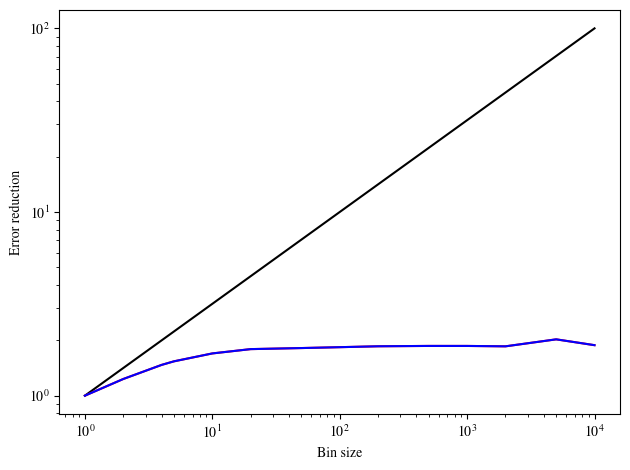

In [28]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep10.pkl", "rb") as aa:
    conf = pickle.load(aa)

model = eval("scalar.Model(geom=(32,), nbeta=32, nt=0, m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [32]:
for i in 1, 2, 4, 8, 10, 16, 20, 50, 100:
    print(f"{i}: {jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=i)}")

1: (np.float32(-4.4554712e-05), np.complex128(0.0001379328673389478+0j))
2: (np.float32(-4.4554712e-05), np.complex128(0.00017078208066421225+0j))
4: (np.float32(-4.4554712e-05), np.complex128(0.00020378611089827504+0j))
8: (np.float32(-4.4554712e-05), np.complex128(0.0002317794193758113+0j))
10: (np.float32(-4.4554712e-05), np.complex128(0.00023268485463712405+0j))
16: (np.float32(-4.4554712e-05), np.complex128(0.00024141567643100735+0j))
20: (np.float32(-4.4554712e-05), np.complex128(0.00024120670102742257+0j))
50: (np.float32(-4.4554712e-05), np.complex128(0.00025072409718850976+0j))
100: (np.float32(-4.4554712e-05), np.complex128(0.0002481313880548667+0j))


In [33]:
for i in 1, 2, 4, 8, 10, 16, 20, 50, 100:
    print(f"{i}: {jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:i]), Bs=50)}")

1: (np.float32(-4.4554712e-05), np.complex128(0.00025072409718850976+0j))
2: (np.float32(1.920552e-06), np.complex128(0.0002614483509278133+0j))
4: (np.float32(1.5256459e-05), np.complex128(0.0003023847057193052+0j))
8: (np.float32(0.000103535625), np.complex128(0.0004354555447185949+0j))
10: (np.float32(-3.0640753e-05), np.complex128(0.0003478549946590766+0j))
16: (np.float32(9.481835e-05), np.complex128(0.0004536472135272082+0j))
20: (np.float32(0.00017021084), np.complex128(0.00048702389176469296+0j))
50: (np.float32(0.0004121821), np.complex128(0.0007615053637882347+0j))
100: (np.float32(0.00016102486), np.complex128(7.955558248795569e-05+0j))


In [31]:
td= 16
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=50), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=50), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=50), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=50)

((np.float32(-4.4554712e-05), np.complex128(0.00025072409718850976+0j)),
 (np.float32(1.920552e-06), np.complex128(0.0002614483509278133+0j)),
 (np.float32(1.5256459e-05), np.complex128(0.0003023847057193052+0j)),
 (np.float32(0.000103535625), np.complex128(0.0004354555447185949+0j)))

In [41]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [40]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017738199676387012 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 4.884750069322763e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00018545009), np.complex128(5.992152867975136e-05+0j)) <f>: (np.float32(-1.3157032e-05), np.complex128(0.0003487322995244748+0j))
Epoch 200: <Test loss>: 3.1723993743071333e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.000122063895), np.complex128(5.226491326301323e-05+0j)) <f>: (np.float32(5.0229046e-05), np.complex128(0.0003108785070069292+0j))
Epoch 300: <Test loss>: 4.085505224793451e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00015430675), np.complex128(6.350894584247738e-05+0j)) <f>: (np.float32(1.

In [42]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017738199676387012 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <f>: (np.float32(0.0), np.complex128(0j))


Epoch 200: <Test loss>: 6.879963166284142e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(9.94477e-05), np.complex128(9.631093693187756e-05+0j)) <f>: (np.float32(7.2845236e-05), np.complex128(0.00034295424066367526+0j))
Epoch 400: <Test loss>: 4.915495082968846e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.000103349295), np.complex128(6.276928875305115e-05+0j)) <f>: (np.float32(6.89438e-05), np.complex128(0.0003076467000844745+0j))
Epoch 600: <Test loss>: 4.301931767258793e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00012542585), np.complex128(5.971339395188339e-05+0j)) <f>: (np.float32(4.6866968e-05), np.complex128(0.00030887061997676653+0j))
Epoch 800: <Test loss>: 1.3974373359815218e-05 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00032848152), np.complex128(9.890928102702293

In [44]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017738199676387012 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.5499184883083217e-05 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(-0.00014563023), np.complex128(0.00011132129587834868+0j)) <f>: (np.float32(0.00031792317), np.complex128(0.0003248509396401383+0j))
Epoch 800: <Test loss>: 6.907230726937996e-06 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(-9.391424e-06), np.complex128(6.062942699686945e-05+0j)) <f>: (np.float32(0.00018168429), np.complex128(0.00032820675285366764+0j))
Epoch 1200: <Test loss>: 2.5364470275235362e-05 <O>: (np.float32(0.00017229297), np.complex128(0.00033261509721346154+0j)) <O-f>: (np.float32(0.00010276806), np.complex128(0.00017170673811889146+0j)) <f>: (np.float3

## sweep1 - bin

jack bin size 1: (np.float32(0.00065247447), np.complex128(4.173847599230104e-05+0j))
bin size 1: (np.float32(0.00065247447), np.complex128(4.173851268769346e-05+0j))
jack bin size 2: (np.float32(0.00065247447), np.complex128(5.783930561343171e-05+0j))
bin size 2: (np.float32(0.00065247447), np.complex128(5.783936656696748e-05+0j))
jack bin size 4: (np.float32(0.00065247447), np.complex128(7.956363328698433e-05+0j))
bin size 4: (np.float32(0.00065247447), np.complex128(7.956354803482777e-05+0j))
jack bin size 5: (np.float32(0.00065247447), np.complex128(8.786031807790393e-05+0j))
bin size 5: (np.float32(0.00065247447), np.complex128(8.786031180461224e-05+0j))
jack bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768341191849774+0j))
bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768340900342145+0j))
jack bin size 20: (np.float32(0.00065247447), np.complex128(0.00015181776692822145+0j))
bin size 20: (np.float32(0.00065247447), np.complex128(0.0001518177917258

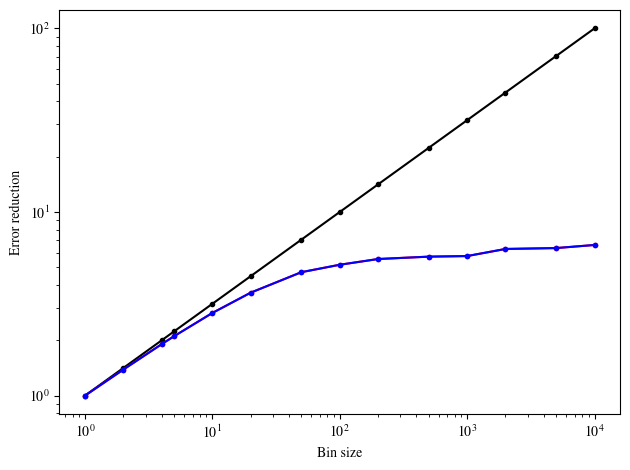

In [18]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,32), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [ ]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017851342272479087 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 4.838381300942274e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(2.9426132e-05), np.complex128(6.147896127182718e-05+0j)) <f>: (np.float32(0.00058373593), np.complex128(0.0005166570519141552+0j))
Epoch 200: <Test loss>: 9.378227332490496e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.0001635133), np.complex128(9.564701961837783e-05+0j)) <f>: (np.float32(0.00044964981), np.complex128(0.00044528328060355725+0j))
Epoch 300: <Test loss>: 2.9184134291426744e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(5.9896905e-05), np.complex128(4.626440820660983e-05+0j)) <f>: (np.float32(0.0005532

In [ ]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017851342272479087 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 6.589034455828369e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(-2.2990414e-05), np.complex128(5.66154567364942e-05+0j)) <f>: (np.float32(0.00063615316), np.complex128(0.0004754532500580845+0j))
Epoch 400: <Test loss>: 4.734599770017667e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(1.714727e-05), np.complex128(5.6737552188940395e-05+0j)) <f>: (np.float32(0.00059601554), np.complex128(0.0004742546705817947+0j))
Epoch 600: <Test loss>: 3.7138222523935838e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(-6.0884802e-05), np.complex128(5.269991845185719e-05+0j)) <f>: (np.float32(0.000674

In [24]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017851342272479087 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.0894580555032007e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(6.358668e-05), np.complex128(8.272419240755819e-05+0j)) <f>: (np.float32(0.000549576), np.complex128(0.0004784441803102804+0j))
Epoch 800: <Test loss>: 7.296806415979518e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(-7.499561e-05), np.complex128(7.504370736554638e-05+0j)) <f>: (np.float32(0.0006881583), np.complex128(0.0004763741949890885+0j))
Epoch 1200: <Test loss>: 5.013740974391112e-06 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(-2.8734565e-05), np.complex128(6.0226937779873133e-05+0j)) <f>: (np.float32(0.00064189

In [26]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017851342272479087 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 2.5508979888400063e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.000103940976), np.complex128(0.0001752945794719354+0j)) <f>: (np.float32(0.00050922146), np.complex128(0.00046121536150254937+0j))
Epoch 1600: <Test loss>: 1.804502790037077e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00010562594), np.complex128(0.0001376628089596758+0j)) <f>: (np.float32(0.0005075365), np.complex128(0.0004490761922067518+0j))
Epoch 2400: <Test loss>: 1.3093153938825708e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00017832986), np.complex128(0.00011350352909357788+0j)) <f>: (np.float32(0.00

In [28]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00017851342272479087 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00010302069131284952 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.0008392912), np.complex128(0.0003082491613390152+0j)) <f>: (np.float32(-0.00022612904), np.complex128(0.00039584181377627474+0j))
Epoch 3200: <Test loss>: 7.83834038884379e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.0007876473), np.complex128(0.000303606283341754+0j)) <f>: (np.float32(-0.00017448522), np.complex128(0.00046354503058622696+0j))
Epoch 4800: <Test loss>: 6.476648559328169e-05 <O>: (np.float32(0.00061316247), np.complex128(0.0005036270353779495+0j)) <O-f>: (np.float32(0.0005990958), np.complex128(0.0002402494553188043+0j)) <f>: (np.float32(1.40671

## sweep1 - pkl

jack bin size 1: (np.float32(-0.00026859494), np.complex128(4.165512866076346e-05+0j))
bin size 1: (np.float32(-0.00026859494), np.complex128(4.165511880292293e-05+0j))
jack bin size 2: (np.float32(-0.00026859494), np.complex128(5.771586174480367e-05+0j))
bin size 2: (np.float32(-0.00026859494), np.complex128(5.771588137737261e-05+0j))
jack bin size 4: (np.float32(-0.00026859494), np.complex128(7.934396848155021e-05+0j))
bin size 4: (np.float32(-0.00026859494), np.complex128(7.934399817653766e-05+0j))
jack bin size 5: (np.float32(-0.00026859494), np.complex128(8.761107903970432e-05+0j))
bin size 5: (np.float32(-0.00026859494), np.complex128(8.761109916150745e-05+0j))
jack bin size 10: (np.float32(-0.00026859494), np.complex128(0.00011723072219819025+0j))
bin size 10: (np.float32(-0.00026859494), np.complex128(0.00011723072634455652+0j))
jack bin size 20: (np.float32(-0.00026859494), np.complex128(0.00015163922532935542+0j))
bin size 20: (np.float32(-0.00026859494), np.complex128(0.0001

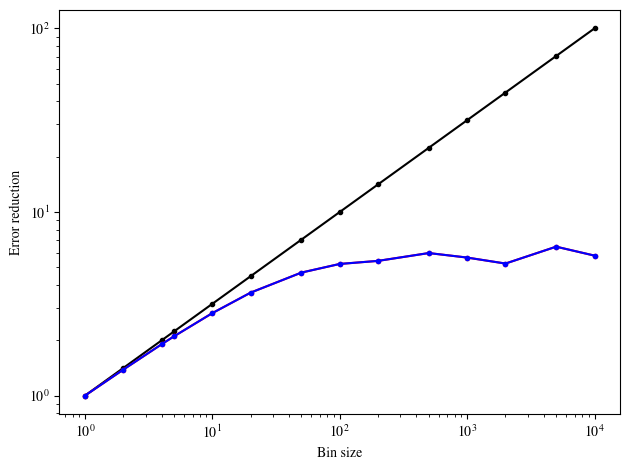

In [4]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,32), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [9]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [8]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 5.21244646733976e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.706873e-05), np.complex128(6.398452265481425e-05+0j)) <f>: (np.float32(0.00025053628), np.complex128(0.0003580384483694219+0j))
Epoch 200: <Test loss>: 3.7355471249611583e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(2.4315666e-06), np.complex128(6.204893826968417e-05+0j)) <f>: (np.float32(0.00028517336), np.complex128(0.0003793555103871217+0j))
Epoch 300: <Test loss>: 3.2295290566253243e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(2.3142647e-05), np.complex128(6.495649332023071e-05+0j)) <f>: (np.float32(0.000

In [10]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 8.054565114434808e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(6.61376e-07), np.complex128(0.0001076374051512588+0j)) <f>: (np.float32(0.0002869437), np.complex128(0.00035611425765694367+0j))
Epoch 400: <Test loss>: 4.757207534566987e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(7.195534e-05), np.complex128(6.468798877776924e-05+0j)) <f>: (np.float32(0.00021564956), np.complex128(0.0003600007607089774+0j))
Epoch 600: <Test loss>: 5.148387572262436e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.2121334e-05), np.complex128(7.909796777733442e-05+0j)) <f>: (np.float32(0.000255

In [11]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [12]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.2305552445468493e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-4.627052e-05), np.complex128(8.293905471458069e-05+0j)) <f>: (np.float32(0.00033387556), np.complex128(0.0003809908711014371+0j))
Epoch 800: <Test loss>: 7.095457476680167e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-7.006801e-06), np.complex128(6.714590209130535e-05+0j)) <f>: (np.float32(0.00029461161), np.complex128(0.0003509541687658601+0j))
Epoch 1200: <Test loss>: 5.479331775859464e-06 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.5693008e-06), np.complex128(4.886342624898929e-05+0j)) <f>: (np.float32(0.0

In [13]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [14]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 2.6263362087775022e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-5.7667974e-05), np.complex128(0.00016113888076379668+0j)) <f>: (np.float32(0.00034527286), np.complex128(0.0003074257405371811+0j))
Epoch 1600: <Test loss>: 1.7718686649459414e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(2.1125106e-06), np.complex128(0.00014154081234776884+0j)) <f>: (np.float32(0.00028549248), np.complex128(0.00031220918014110286+0j))
Epoch 2400: <Test loss>: 1.3387407307163812e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(3.9413102e-05), np.complex128(0.00011860894897078929+0j)) <f>: (np.flo

In [15]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [16]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00018035263929050416 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 8.634312689537182e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00010962964), np.complex128(0.00033992204898317043+0j)) <f>: (np.float32(0.0003972343), np.complex128(0.0002765369151763884+0j))
Epoch 3200: <Test loss>: 8.601634908700362e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-0.00028898154), np.complex128(0.0003287590724339912+0j)) <f>: (np.float32(0.0005765875), np.complex128(0.0002811476974277244+0j))
Epoch 4800: <Test loss>: 5.787106420029886e-05 <O>: (np.float32(0.00028760495), np.complex128(0.00037218299919742953+0j)) <O-f>: (np.float32(-7.867418e-05), np.complex128(0.0002612220906559233+0j)) <f>: (np.float32(0

## m^2=0.01, lambda=0.1

jack bin size 1: (np.float32(0.0026315458), np.complex128(0.00014273172330526426+0j))
bin size 1: (np.float32(0.0026315458), np.complex128(0.00014273153766844907+0j))
jack bin size 2: (np.float32(0.0026315458), np.complex128(0.0002009817562697372+0j))
bin size 2: (np.float32(0.0026315458), np.complex128(0.0002009828085752801+0j))
jack bin size 4: (np.float32(0.0026315458), np.complex128(0.0002824853088164997+0j))
bin size 4: (np.float32(0.0026315458), np.complex128(0.0002824858900202818+0j))
jack bin size 5: (np.float32(0.0026315458), np.complex128(0.00031500454263360945+0j))
bin size 5: (np.float32(0.0026315458), np.complex128(0.00031500483356931857+0j))
jack bin size 10: (np.float32(0.0026315458), np.complex128(0.00043987794528254736+0j))
bin size 10: (np.float32(0.0026315458), np.complex128(0.0004398786801819173+0j))
jack bin size 20: (np.float32(0.0026315458), np.complex128(0.0006075311796406414+0j))
bin size 20: (np.float32(0.0026315458), np.complex128(0.0006075311335893693+0j))
j

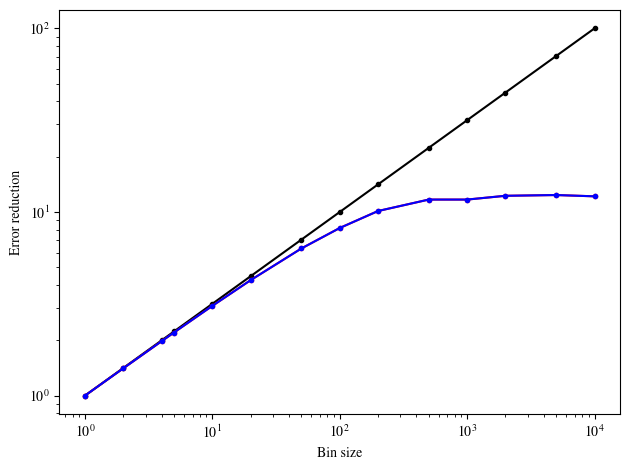

In [14]:
with open("1+1scalar/config/c_32x32_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,32), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [25]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [26]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.00018472775991540402 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.00809773), np.complex128(0.00041512006647895304+0j)) <f>: (np.float32(0.00019001847), np.complex128(0.0021500927509228167+0j))
Epoch 200: <Test loss>: 0.00012986133515369147 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008082474), np.complex128(0.00037356987160213625+0j)) <f>: (np.float32(0.00020527297), np.complex128(0.0022533233261133605+0j))
Epoch 300: <Test loss>: 0.0001209946713061072 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007963734), np.complex128(0.0003222437311566668+0j)) <f>: (np.float32(0.00032401254), np.comple

In [27]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [28]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0002153656241716817 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008476562), np.complex128(0.00038123130375940044+0j)) <f>: (np.float32(-0.00018880647), np.complex128(0.002335472704960558+0j))
Epoch 400: <Test loss>: 0.00018196244491264224 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008325658), np.complex128(0.0003802493705681058+0j)) <f>: (np.float32(-3.7908816e-05), np.complex128(0.0022532834918674296+0j))
Epoch 600: <Test loss>: 0.0001631522609386593 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008137307), np.complex128(0.000318120284114705+0j)) <f>: (np.float32(0.00015043955), np.complex

In [29]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [30]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00025622069370001554 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008522707), np.complex128(0.0005048361442886732+0j)) <f>: (np.float32(-0.00023496107), np.complex128(0.0022508617219476187+0j))
Epoch 800: <Test loss>: 0.00024068444326985627 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008348743), np.complex128(0.0004440245374612397+0j)) <f>: (np.float32(-6.099568e-05), np.complex128(0.0021992266440900373+0j))
Epoch 1200: <Test loss>: 0.00022061598428990692 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008283083), np.complex128(0.00045774889408197155+0j)) <f>: (np.float32(4.6601594e-06), np.com

In [31]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [32]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0004047975526191294 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.0085852435), np.complex128(0.000637978242062653+0j)) <f>: (np.float32(-0.00029749135), np.complex128(0.002279666956181882+0j))
Epoch 1600: <Test loss>: 0.00039470120100304484 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008609237), np.complex128(0.0006171290738588213+0j)) <f>: (np.float32(-0.00032148458), np.complex128(0.0020967204432442875+0j))
Epoch 2400: <Test loss>: 0.00036334682954475284 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008563202), np.complex128(0.0006715037710093979+0j)) <f>: (np.float32(-0.00027546159), np.com

In [33]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [34]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0007346804486587644 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008720938), np.complex128(0.0009266796669508411+0j)) <f>: (np.float32(-0.00043318933), np.complex128(0.001748786699833104+0j))
Epoch 3200: <Test loss>: 0.0007453602738678455 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.00875156), np.complex128(0.0009365732123474491+0j)) <f>: (np.float32(-0.00046380138), np.complex128(0.0017513331737775966+0j))
Epoch 4800: <Test loss>: 0.0007189736934378743 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008711458), np.complex128(0.0009726464838452448+0j)) <f>: (np.float32(-0.0004237135), np.comple

### l4, w64

In [15]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [16]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.00019824346236418933 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007783222), np.complex128(0.0004463675269137795+0j)) <f>: (np.float32(0.0005045228), np.complex128(0.002143435864868749+0j))
Epoch 200: <Test loss>: 0.00015587535744998604 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007991228), np.complex128(0.0004344052648025381+0j)) <f>: (np.float32(0.0002965154), np.complex128(0.0021116575243044344+0j))
Epoch 300: <Test loss>: 0.00014729845861438662 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007935573), np.complex128(0.000429854582786902+0j)) <f>: (np.float32(0.00035217297), np.complex128

In [17]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [18]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.00025555980391800404 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.00740129), np.complex128(0.0005659094646490858+0j)) <f>: (np.float32(0.0008864575), np.complex128(0.0022256357342569674+0j))
Epoch 400: <Test loss>: 0.00019390425586607307 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007582245), np.complex128(0.0004957225382041133+0j)) <f>: (np.float32(0.0007055018), np.complex128(0.0021383312457994275+0j))
Epoch 600: <Test loss>: 0.00018161813204642385 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007480251), np.complex128(0.00047662401533558337+0j)) <f>: (np.float32(0.0008074958), np.complex12

In [19]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0003215968899894506 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008198481), np.complex128(0.0006673927245965435+0j)) <f>: (np.float32(8.926642e-05), np.complex128(0.0019940328316606997+0j))
Epoch 800: <Test loss>: 0.0002596214471850544 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008007853), np.complex128(0.0005993366131572339+0j)) <f>: (np.float32(0.0002798965), np.complex128(0.0020133377251011025+0j))
Epoch 1200: <Test loss>: 0.0002531628997530788 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008204578), np.complex128(0.0006136256899873968+0j)) <f>: (np.float32(8.317441e-05), np.complex128(

In [21]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [22]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0004624943248927593 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.0075229877), np.complex128(0.000663434798995277+0j)) <f>: (np.float32(0.00076475856), np.complex128(0.0019714582316769126+0j))
Epoch 1600: <Test loss>: 0.00040065974462777376 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007771261), np.complex128(0.0006808784563236576+0j)) <f>: (np.float32(0.00051648443), np.complex128(0.0019434354739678145+0j))
Epoch 2400: <Test loss>: 0.00039411018951795995 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007799995), np.complex128(0.0006659603409315575+0j)) <f>: (np.float32(0.00048775005), np.compl

In [23]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [24]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.002505482407286763 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0008983048028312624 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008126524), np.complex128(0.0011361598472193913+0j)) <f>: (np.float32(0.00016122495), np.complex128(0.001523542180167734+0j))
Epoch 3200: <Test loss>: 0.0008421388338319957 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.007872938), np.complex128(0.0011666206130122468+0j)) <f>: (np.float32(0.00041480502), np.complex128(0.0014426526544935926+0j))
Epoch 4800: <Test loss>: 0.0008625198970548809 <O>: (np.float32(0.008287755), np.complex128(0.0023403281697018277+0j)) <O-f>: (np.float32(0.008072459), np.complex128(0.0012484821450313643+0j)) <f>: (np.float32(0.00021528822), np.complex

# 64x64

## Sweep 10

jack bin size 1: (np.float32(3.405124e-05), np.complex128(1.0658076532853887e-05+0j))
bin size 1: (np.float32(3.405124e-05), np.complex128(1.065807480584099e-05+0j))
jack bin size 2: (np.float32(3.405124e-05), np.complex128(1.3135326250680487e-05+0j))
bin size 2: (np.float32(3.405124e-05), np.complex128(1.3135326786436573e-05+0j))
jack bin size 4: (np.float32(3.405124e-05), np.complex128(1.5655767322892354e-05+0j))
bin size 4: (np.float32(3.405124e-05), np.complex128(1.5655769771065156e-05+0j))
jack bin size 5: (np.float32(3.405124e-05), np.complex128(1.63665270248193e-05+0j))
bin size 5: (np.float32(3.405124e-05), np.complex128(1.636652599978707e-05+0j))
jack bin size 10: (np.float32(3.405124e-05), np.complex128(1.805728205996368e-05+0j))
bin size 10: (np.float32(3.405124e-05), np.complex128(1.8057281353648882e-05+0j))
jack bin size 20: (np.float32(3.405124e-05), np.complex128(1.8911975856213364e-05+0j))
bin size 20: (np.float32(3.405124e-05), np.complex128(1.8911982022243948e-05+0j))

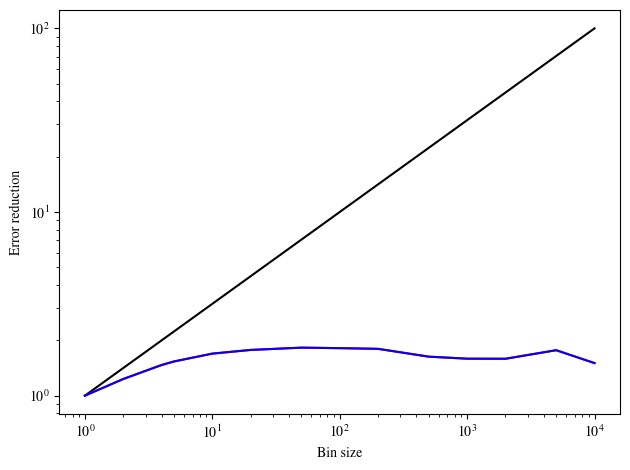

In [ ]:
### OLD
with open("1+1scalar/config/c_64x64_0.1_0.5_sweep10.pkl", "rb") as aa:
    conf = pickle.load(aa)

model = eval("scalar.Model(geom=(64,), nbeta=64, nt=0, m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(3.405124e-05), np.complex128(1.0658076532853887e-05+0j))
bin size 1: (np.float32(3.405124e-05), np.complex128(1.065807480584099e-05+0j))
jack bin size 2: (np.float32(3.405124e-05), np.complex128(1.3135326250680487e-05+0j))
bin size 2: (np.float32(3.405124e-05), np.complex128(1.3135326786436573e-05+0j))
jack bin size 4: (np.float32(3.405124e-05), np.complex128(1.5655767322892354e-05+0j))
bin size 4: (np.float32(3.405124e-05), np.complex128(1.5655769771065156e-05+0j))
jack bin size 5: (np.float32(3.405124e-05), np.complex128(1.63665270248193e-05+0j))
bin size 5: (np.float32(3.405124e-05), np.complex128(1.636652599978707e-05+0j))
jack bin size 10: (np.float32(3.405124e-05), np.complex128(1.805728205996368e-05+0j))
bin size 10: (np.float32(3.405124e-05), np.complex128(1.8057281353648882e-05+0j))
jack bin size 20: (np.float32(3.405124e-05), np.complex128(1.8911975856213364e-05+0j))
bin size 20: (np.float32(3.405124e-05), np.complex128(1.8911982022243948e-05+0j))

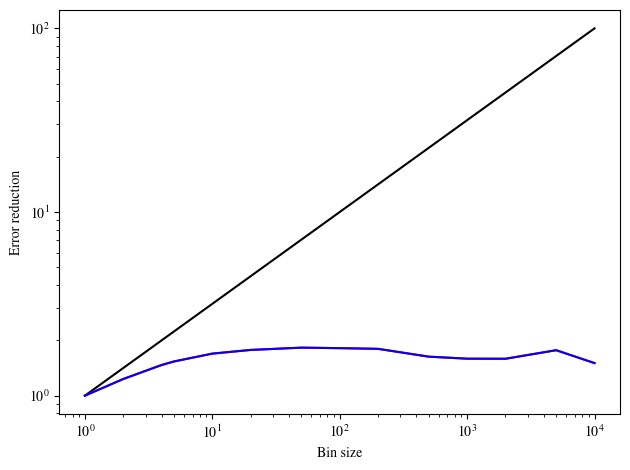

In [24]:
with open("1+1scalar/config/c_64x64_0.1_0.5_sweep10.pkl", "rb") as aa:
    conf = pickle.load(aa)

model = eval("scalar.Model(geom=(64,64), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [64]:
td= 32
bs=25
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=bs)

((np.float32(0.00016814486), np.complex128(8.521981245694444e-05+0j)),
 (np.float32(0.00016147953), np.complex128(9.315137365994952e-05+0j)),
 (np.float32(0.0001011854), np.complex128(0.00010297631899207494+0j)),
 (np.float32(0.00011900659), np.complex128(0.0001384937932016328+0j)))

In [63]:
td= 32
bs=50
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=bs)

((np.float32(0.00016814486), np.complex128(8.845423308216592e-05+0j)),
 (np.float32(0.00016147953), np.complex128(8.514809730518216e-05+0j)),
 (np.float32(0.0001011854), np.complex128(9.03889140317915e-05+0j)),
 (np.float32(0.00011900659), np.complex128(0.00013565501888460808+0j)))

In [65]:
td= 32
bs= 100
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=bs)

((np.float32(0.00016814486), np.complex128(8.228795720818279e-05+0j)),
 (np.float32(0.00016147953), np.complex128(6.908529667271068e-05+0j)),
 (np.float32(0.0001011854), np.complex128(8.285808789440219e-05+0j)),
 (np.float32(8.325212e-05), np.complex128(0.00014569042908347925+0j)))

In [68]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])


def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [67]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.1918727725278586e-05 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 5.108173809276195e-06 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-7.255829e-05), np.complex128(6.282167031072281e-05+0j)) <f>: (np.float32(-6.5397646e-05), np.complex128(0.00011857500581656355+0j))
Epoch 200: <Test loss>: 8.661161814416118e-07 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-2.6876056e-05), np.complex128(2.7611850098268984e-05+0j)) <f>: (np.float32(-0.000111079775), np.complex128(0.00011392708510823312+0j))
Epoch 300: <Test loss>: 7.554125431852299e-07 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-5.3034182e-05), np.complex128(2.690814412938656e-05+0j)) <f>: (np.

In [69]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.1918727725278586e-05 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 9.337839401268866e-06 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-0.00015378016), np.complex128(0.00011106965190992623+0j)) <f>: (np.float32(1.5824267e-05), np.complex128(0.00017470508971945345+0j))
Epoch 400: <Test loss>: 2.816008645822876e-06 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(8.8360075e-06), np.complex128(6.0875905357962295e-05+0j)) <f>: (np.float32(-0.00014679194), np.complex128(0.0001261645555547176+0j))
Epoch 600: <Test loss>: 1.41491909744218e-06 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-4.5214696e-05), np.complex128(4.4765387017753134e-05+0j)) <f>: (np.fl

In [71]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.1918727725278586e-05 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0008733688737265766 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(0.00061379425), np.complex128(0.0008139577580730011+0j)) <f>: (np.float32(-0.0007517505), np.complex128(0.0008240275763508859+0j))
Epoch 800: <Test loss>: 3.497249053907581e-05 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(-5.1782963e-06), np.complex128(0.0001758163414917857+0j)) <f>: (np.float32(-0.00013277747), np.complex128(0.00019088470747313547+0j))
Epoch 1200: <Test loss>: 3.781350824283436e-05 <O>: (np.float32(-0.00013795587), np.complex128(0.00011188290800171183+0j)) <O-f>: (np.float32(0.00019811057), np.complex128(0.0001593502248044917+0j)) <f>: (np.floa

## sweep 1

jack bin size 1: (np.float32(-0.00011681768), np.complex128(1.5184077730095093e-05+0j))
bin size 1: (np.float32(-0.00011681768), np.complex128(1.5183940980571554e-05+0j))
jack bin size 2: (np.float32(-0.00011681768), np.complex128(2.1067158836151646e-05+0j))
bin size 2: (np.float32(-0.00011681768), np.complex128(2.1067123963546364e-05+0j))
jack bin size 4: (np.float32(-0.00011681768), np.complex128(2.9006948315715688e-05+0j))
bin size 4: (np.float32(-0.00011681768), np.complex128(2.9006846226500887e-05+0j))
jack bin size 5: (np.float32(-0.00011681768), np.complex128(3.205067928375791e-05+0j))
bin size 5: (np.float32(-0.00011681768), np.complex128(3.20506346561429e-05+0j))
jack bin size 10: (np.float32(-0.00011681768), np.complex128(4.3061662024710435e-05+0j))
bin size 10: (np.float32(-0.00011681768), np.complex128(4.3061698707887046e-05+0j))
jack bin size 20: (np.float32(-0.00011681768), np.complex128(5.578131639187397e-05+0j))
bin size 20: (np.float32(-0.00011681768), np.complex128(5.

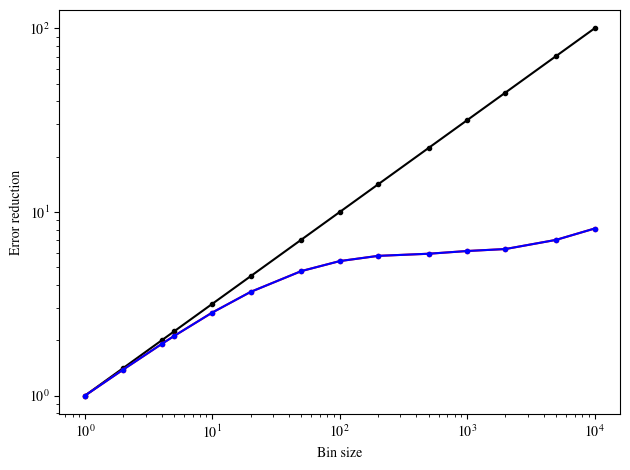

In [3]:
with open("1+1scalar/config/c_64x64_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(64,64), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.5106241082539782e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 5.05856496602064e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(0.00011667244), np.complex128(5.3624098329584885e-05+0j)) <f>: (np.float32(-0.00018045455), np.complex128(0.0001812264727355118+0j))
Epoch 200: <Test loss>: 1.0848041256394936e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(6.672085e-05), np.complex128(3.636521354642196e-05+0j)) <f>: (np.float32(-0.00013050313), np.complex128(0.00018949550400387783+0j))
Epoch 300: <Test loss>: 8.757203318054962e-07 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(3.0016503e-07), np.complex128(3.362667256900154e-05+0j)) <f>: (np.float32(-6.4082

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.5106241082539782e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 7.569273748231353e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-4.474047e-05), np.complex128(0.00011160772345284176+0j)) <f>: (np.float32(-1.9041667e-05), np.complex128(0.00013782720451205058+0j))
Epoch 400: <Test loss>: 1.0624934475345071e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(2.4617977e-05), np.complex128(8.811629358057434e-05+0j)) <f>: (np.float32(-8.84001e-05), np.complex128(0.0001817840094603064+0j))
Epoch 800: <Test loss>: 1.483207825003774e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(3.612586e-05), np.complex128(3.891447446094726e-05+0j)) <f>: (np.float32(-9.99080

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.5106241082539782e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.5262208762578666e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-3.5496345e-05), np.complex128(0.00014264556251148975+0j)) <f>: (np.float32(-2.8285836e-05), np.complex128(0.00018111415348235558+0j))
Epoch 800: <Test loss>: 9.508198672847357e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-4.343863e-05), np.complex128(0.0001057502022487462+0j)) <f>: (np.float32(-2.0343417e-05), np.complex128(0.0001473273232997631+0j))
Epoch 1200: <Test loss>: 5.763189165008953e-06 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-2.8716066e-05), np.complex128(7.235745676470124e-05+0j)) <f>: (np.float32(-3

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.5106241082539782e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 3.487565481918864e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-0.0002162993), np.complex128(0.00023542667305399302+0j)) <f>: (np.float32(0.00015251743), np.complex128(0.0001398093388290796+0j))
Epoch 1600: <Test loss>: 6.188396218931302e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(1.8753291e-05), np.complex128(0.00024578628864254146+0j)) <f>: (np.float32(-8.2535385e-05), np.complex128(0.0001872261571620478+0j))
Epoch 2400: <Test loss>: 0.00014460146485362202 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-8.947731e-05), np.complex128(0.00045270415324220225+0j)) <f>: (np.float32(2.5

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.5106241082539782e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 3.919073787983507e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(6.983551e-06), np.complex128(0.00023882967843149143+0j)) <f>: (np.float32(-7.076571e-05), np.complex128(0.0001629941227098309+0j))
Epoch 3200: <Test loss>: 4.1655755921965465e-05 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(0.00012961958), np.complex128(0.0002426936478595332+0j)) <f>: (np.float32(-0.00019340163), np.complex128(0.00011726694559429172+0j))
Epoch 4800: <Test loss>: 0.00014452997129410505 <O>: (np.float32(-6.378219e-05), np.complex128(0.0001931476161366821+0j)) <O-f>: (np.float32(-0.0004428516), np.complex128(0.0003705830643212549+0j)) <f>: (np.float32(0.0

## m^2=0.01, lambda=0.1

jack bin size 1: (np.float32(5.373278e-05), np.complex128(5.118669839799836e-05+0j))
bin size 1: (np.float32(5.373278e-05), np.complex128(5.1186445507927655e-05+0j))
jack bin size 2: (np.float32(5.373278e-05), np.complex128(7.207437158027468e-05+0j))
bin size 2: (np.float32(5.373278e-05), np.complex128(7.207435004186308e-05+0j))
jack bin size 4: (np.float32(5.373278e-05), np.complex128(0.000101308309987129+0j))
bin size 4: (np.float32(5.373278e-05), np.complex128(0.00010130831427076855+0j))
jack bin size 5: (np.float32(5.373278e-05), np.complex128(0.00011296436050799229+0j))
bin size 5: (np.float32(5.373278e-05), np.complex128(0.00011296424117195282+0j))
jack bin size 10: (np.float32(5.373278e-05), np.complex128(0.00015773930730523085+0j))
bin size 10: (np.float32(5.373278e-05), np.complex128(0.0001577392861015754+0j))
jack bin size 20: (np.float32(5.373278e-05), np.complex128(0.0002179955464750625+0j))
bin size 20: (np.float32(5.373278e-05), np.complex128(0.00021799555468518113+0j))
j

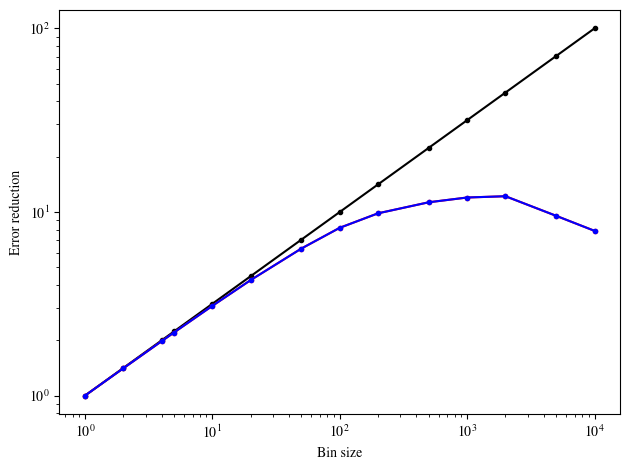

In [3]:
with open("1+1scalar/config/c_64x64_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(64,64), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [4]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 4.576784704113379e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.000633756), np.complex128(0.00020171402463989763+0j)) <f>: (np.float32(-0.00023897823), np.complex128(0.0008797154081499675+0j))
Epoch 200: <Test loss>: 4.100240039406344e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00030929167), np.complex128(0.00015881950325082335+0j)) <f>: (np.float32(8.548694e-05), np.complex128(0.0007503953682148595+0j))
Epoch 300: <Test loss>: 2.737485738180112e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477303), np.complex128(0.00013510915153054686+0j)) <f>: (np.float32(5.2098184

In [38]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [39]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.00010507788101676852 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00014799382), np.complex128(0.0004125275738315579+0j)) <f>: (np.float32(0.00024678494), np.complex128(0.0006174436882852818+0j))
Epoch 400: <Test loss>: 5.974874511593953e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00022990559), np.complex128(0.0002546848183427221+0j)) <f>: (np.float32(0.00016487349), np.complex128(0.0006716998341529844+0j))
Epoch 600: <Test loss>: 5.504344153450802e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00018489553), np.complex128(0.0002268789447823486+0j)) <f>: (np.float32(0.0002098

In [40]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [41]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0002248995442641899 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0006408646), np.complex128(0.00040486243100011063+0j)) <f>: (np.float32(-0.0002460856), np.complex128(0.00073187694741028+0j))
Epoch 800: <Test loss>: 0.00012711537419818342 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00033741788), np.complex128(0.0003083228990952169+0j)) <f>: (np.float32(5.73614e-05), np.complex128(0.0006061823947278337+0j))
Epoch 1200: <Test loss>: 0.00024323511752299964 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0009658083), np.complex128(0.0005581646216106128+0j)) <f>: (np.float32(-0.000571030

In [42]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [43]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.00024070516519714147 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00058130955), np.complex128(0.0007089548760901723+0j)) <f>: (np.float32(-0.00018653115), np.complex128(0.00034880426123149485+0j))
Epoch 1600: <Test loss>: 0.00023891107412055135 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00026603634), np.complex128(0.0006967453625607166+0j)) <f>: (np.float32(0.00012874314), np.complex128(0.00030949331550591224+0j))
Epoch 2400: <Test loss>: 0.00017767635290510952 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(-1.1696726e-05), np.complex128(0.00039636806349182505+0j)) <f>: (np.float32(

In [44]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [45]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0006040514563210309 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0011557353), np.complex128(0.0009823168179179183+0j)) <f>: (np.float32(-0.0007609556), np.complex128(0.0005229537488511551+0j))
Epoch 3200: <Test loss>: 0.00030090779182501137 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0004978873), np.complex128(0.0006819197285867171+0j)) <f>: (np.float32(-0.00010310868), np.complex128(0.00027069495026021414+0j))
Epoch 4800: <Test loss>: 0.0003842975711449981 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00017260031), np.complex128(0.0008582163328063145+0j)) <f>: (np.float32(0.0002

### l4, w64

In [26]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [27]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 7.625293801538646e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0005897171), np.complex128(0.0002779838243864671+0j)) <f>: (np.float32(-0.00019493829), np.complex128(0.000714960840119172+0j))
Epoch 200: <Test loss>: 5.3130181186133996e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00041044716), np.complex128(0.00022701210089822504+0j)) <f>: (np.float32(-1.5668042e-05), np.complex128(0.0007219166733087051+0j))
Epoch 300: <Test loss>: 5.0858296162914485e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039467704), np.complex128(0.00020481951006430873+0j)) <f>: (np.float32(1.0151

In [28]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [29]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 9.268506983062252e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00044994365), np.complex128(0.00026421844420115593+0j)) <f>: (np.float32(-5.5164703e-05), np.complex128(0.0007210447600211797+0j))
Epoch 400: <Test loss>: 7.965499389683828e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00069196726), np.complex128(0.0002966870177362642+0j)) <f>: (np.float32(-0.0002971896), np.complex128(0.0006596705261851364+0j))
Epoch 600: <Test loss>: 8.562606672057882e-05 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0004782409), np.complex128(0.0003254887950176558+0j)) <f>: (np.float32(-8.346137

In [30]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [31]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00011193117825314403 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0005914355), np.complex128(0.00042982638800614356+0j)) <f>: (np.float32(-0.00019665675), np.complex128(0.0006720911358458946+0j))
Epoch 1200: <Test loss>: 0.00010801247844938189 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00044121753), np.complex128(0.0003587288874887813+0j)) <f>: (np.float32(-4.6438206e-05), np.complex128(0.0005278561203199182+0j))
Epoch 1600: <Test loss>: 0.0001189841641462408 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00047323227), np.complex128(0.0004447219856318337+0j)) <f>: (np.float32(-7.8

In [32]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [33]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.00028865449712611735 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0005621541), np.complex128(0.00047856450764233594+0j)) <f>: (np.float32(-0.00016737482), np.complex128(0.0005856009025078052+0j))
Epoch 1600: <Test loss>: 0.00017362303333356977 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0006264718), np.complex128(0.0005246065211904833+0j)) <f>: (np.float32(-0.00023169373), np.complex128(0.0003451093812000936+0j))
Epoch 2400: <Test loss>: 0.0001636623201193288 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00048560684), np.complex128(0.0004862494724512568+0j)) <f>: (np.float32(-9.08

In [34]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [35]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00032038590870797634 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00027966024936176836 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0005801644), np.complex128(0.0006403412754988141+0j)) <f>: (np.float32(-0.00018538568), np.complex128(0.00027072990037089556+0j))
Epoch 3200: <Test loss>: 0.00028032291447743773 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.0004224315), np.complex128(0.0007657169639228295+0j)) <f>: (np.float32(-2.7652019e-05), np.complex128(0.0002417288884295216+0j))
Epoch 4800: <Test loss>: 0.0002248897944809869 <O>: (np.float32(0.00039477917), np.complex128(0.0008224727721530231+0j)) <O-f>: (np.float32(0.00047898156), np.complex128(0.0006502185827314756+0j)) <f>: (np.float32(-8.4